# Chrome Dino re-write 2023

Use Pytorch, stable-baselines3, etc. to build a model to play chrome://dino with reinforcement learning.

## dependencies
- CUDA-enabled Pytorch (Pytorch 2.00; CUDA 1.18)
- Stable-Baselines3 (with extras like OpenCV): https://stable-baselines3.readthedocs.io/en/master/
- Protobuf (a training dependency) (3.20.*)
- pytesseract (interface to Google Tesseract)
- Google Tesseract-OCR ((5.3.1.20230401)
- Gym (gym v0.21 since this is used by Stable-Baselines3; RL environment library): https://gymnasium.farama.org/
- MSS (crossplatform screenshots)
- openCV (2)
- selenium (chrome test driver) (ChromeDriver 112.0.5615.49)

In [ ]:
%%capture
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
%%capture
# needed to support old version of gym (0.21) used with Stable-Baselines3
# gym 0.21 has installation issue; gym moved to Gymnasium; SB3 still does not support Gymnasium 
!pip install setuptools==66 Cmake git+https://github.com/openai/gym.git@9180d12e1b66e7e2a1a622614f787a6ec147ac40

In [ ]:
%%capture
!pip install stable-baselines3[extra] protobuf==3.20.*

In [ ]:
%%capture
!pip install mss pydirectinput pytesseract selenium webdriver-manager

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

from mss import mss
from gym import Env
from gym.spaces import Box, Discrete

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import WebDriverException

## set up environment

In [2]:
# create a base Gym environment for managing state
# Env must implement step and reset; optionally, render 
# https://www.gymlibrary.dev/api/core/
class ChromeDinoRL(Env):
    
    # initialize environment spaces
    def __init__(self):
        super().__init__()
        
        # observation parameters
        self.capture = mss()
        self.game_window = {'top':120, 'left':20, 'width':560, 'height':300}
        self.game_over_window = {'top':1, 'left':1, 'width':1, 'height':1}
        
        self.obs_width = int(self.game_window["width"] / 4)
        self.obs_height = int(self.game_window["height"] / 4)
        
        # set up observations and actions
        # multidimensional array as return output from observation (an image)
        self.observation_space = Box(low=0, high=255, shape=(1, self.obs_height, self.obs_width), dtype=np.uint8)
        # two actions: jump or not
        self.action_space = Discrete(2)
        
    # run one timestep in the environment
    def step(self, action):
        # 0 -> spacebar, 1 -> noop
        action_map = {
            0: 'space',
            1: 'no_op'
        }
        
        
    # reset to initial state, return initial observation
    def reset(self):
        pass
        
    # compute render frames for visualization; render with cv2
    # close everything with "q" 
    def render(self):
        cv2.imshow('Chrome Dino', self.current_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
        
    # do an observation
    def observe_env(self):        
        #obs = self.capture.grab(self.game_window)
        obs = np.array(self.capture.grab(self.game_window)).astype(np.uint8)
        
        # preprocessing -> grayscale, shrink, then reshape for Stable Baselines
        gray = cv2.cvtColor(obs, cv2.COLOR_BGR2GRAY)
        shrunk = cv2.resize(gray, (self.obs_width, self.obs_height))
        channel = np.reshape(shrunk, (1, self.obs_height, self.obs_width))
        
        return channel
        
    # identify game over
    def game_over(self):
        pass
    
    def close(self):
        cv2.destroyAllWindows()
        self.driver.end()
    

## set up driver

automated window setup for consistent environment

In [3]:
# set up webdriver for selenium on chrome
# requires chromedriver present in path specified
class ChromeDinoDriver():

    def __init__(self):
        self.chrome_driver = None
        self.chrome_path = r"chromedriver\chromedriver.exe" 
        self.startpage = "chrome://dino/"
        self.chrome_options = Options()
        self.chrome_options.add_argument("--window-size=640,480")
        
    # set up and run driver
    # options 
    def run(self):
        #self.chrome_driver = webdriver.Chrome(executable_path=self.chrome_path, options=self.chrome_options)
        self.chrome_driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=self.chrome_options)
        self.chrome_driver.set_window_position(0, 0, windowHandle='current')
        try:
            self.chrome_driver.get("chrome://dino")
        except WebDriverException:
            pass # ignore selenium complaining about offline

    def end(self): # close driver
        # duplicates are automatically closed by new selenium service
        self.chrome_driver.quit()

### misc testing

In [4]:
# test environment
env = ChromeDinoRL()

0


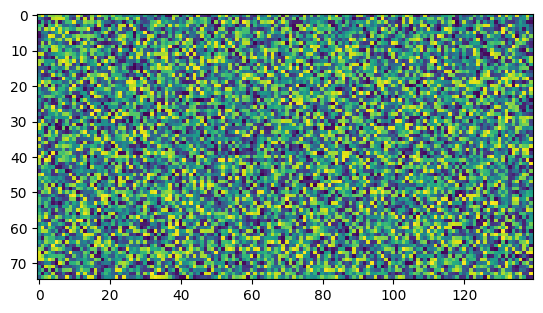

In [5]:
# random action; observation space empty
print(env.action_space.sample())
plt.imshow(env.observation_space.sample()[0])

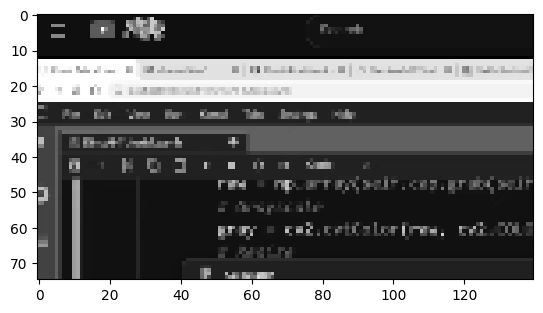

In [6]:
# try an observation
obs = env.observe_env()
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_BGR2RGB))

In [7]:
# test driver
driver = ChromeDinoDriver()
driver.run()
time.sleep(2)
driver.end()

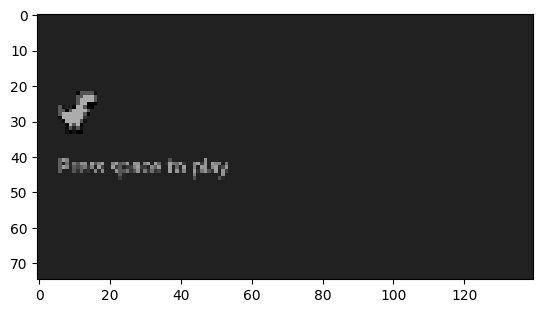

In [10]:
# start driver and try an observation
driver = ChromeDinoDriver()
driver.run()
plt.imshow(cv2.cvtColor(env.observe_env()[0], cv2.COLOR_BGR2RGB))
driver.end()

## train model

Train the DQN and save it using a Stable-Baselines3 callback

In [ ]:
# training imports
from stable_baselines3 import DQN
from stablebaselines3.common.callbacks import BaseCallback
import os